<a href="https://colab.research.google.com/github/ddasdibakardas/Fractal_Analysis/blob/master/India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import os
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

def curve_length(X,opt=False,num_k=50,k_max=None):
    """
    Calculate curve length <Lk> for Higuchi Fractal Dimension (HFD)
    
    Input:
    
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    opt (=True) - optimized? (if libhfd.so was compiled uses the faster code).
    num_k - number of k values to generate.
    k_max - the maximum k (the k array is generated uniformly in log space 
            from 2 to k_max)
    Output:
    k - interval "times", window sizes
    Lk - curve length
    """
    ### Make sure X is a NumPy array with the correct dimension
    X = np.array(X)
    if X.ndim != 1:
        raise ValueError("Input array must be 1D (time series).")
    N = X.size

    ### Get interval "time"
    k_arr = interval_t(N,num_val=num_k,kmax=k_max)

    ### The average length
    Lk = np.empty(k_arr.size,dtype=np.float)

    ### C library
    '''
    if opt:
        X = np.require(X, float, ('C', 'A'))
        k_arr = np.require(k_arr, ctypes.c_size_t, ('C', 'A'))
        Lk = np.require(Lk, float, ('C', 'A'))
        ## Load library here
        libhfd = init_lib()
        ## Run the C code here
        libhfd.curve_length(k_arr,k_arr.size,X,N,Lk)
    '''
    #else:
        ### Native Python run
    for i in range(k_arr.size):# over array of k's
            Lmk = 0.0
            for j in range(k_arr[i]):# over m's
                ## Construct X_k^m, i.e. X_(k_arr[i])^j, as X[j::k_arr[i]]
                ## Calculate L_m(k)
                Lmk += (
                    np.sum(
                        np.abs(
                            np.diff( X[j::k_arr[i]] )
                        )
                    )
                    * (N - 1) /
                    (
                        ( (N-j-1)//k_arr[i] )
                        *
                        k_arr[i]
                    )
                ) / k_arr[i]

            ### Calculate the average Lmk
            Lk[i] = Lmk / k_arr[i]

    return (k_arr, Lk);

def lin_fit_hfd(k,L,log=True):
    """
    Calculate Higuchi Fractal Dimension (HFD) by fitting a line to already computed
    interval times k and curve lengths L
    Input:
    k - interval "times", window sizes
    L - curve length
    log (=True) - k and L values will be transformed to np.log2(k) and np.log2(L),
                  respectively
    Output:
    HFD
    """
    if log:
        return (-np.polyfit(np.log2(k),np.log2(L),deg=1)[0]);
    else:
        return (-np.polyfit(k,L,deg=1)[0]);

def hfd(X,**kwargs):
    """
    Calculate Higuchi Fractal Dimension (HFD) for 1D data/series
    Input:
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    Output:
    
    HFD
    """
    k, L = curve_length(X,**kwargs)
    return lin_fit_hfd(k, L);

# Generating th interval
def interval_t(size,num_val=50,kmax=None):
    list_space = []
    ### Generate sequence of interval times, k
    if kmax is None:
        k_stop = size//2
    else:
        k_stop = kmax
    if k_stop > size//2:   ## prohibit going larger than N/2
        k_stop = size//2
        print("Warning: k cannot be longer than N/2")
    for i in range(2, k_stop):
      list_space.append(i)    
    #k = np.logspace(start=np.log2(2),stop=np.log2(k_stop),base=2,num=num_val,dtype=np.int)
    return np.unique(list_space);

def init_lib():
    libdir = os.path.dirname(__file__)
    libfile = os.path.join(libdir, "libhfd.so")
    lib = ctypes.CDLL(libfile)

    rwptr = ndpointer(float, flags=('C','A','W'))
    rwptr_sizet = ndpointer(ctypes.c_size_t, flags=('C','A','W'))

    lib.curve_length.restype = ctypes.c_int
    lib.curve_length.argtypes = [rwptr_sizet, ctypes.c_size_t, rwptr, ctypes.c_size_t, rwptr]

    return lib;

In [3]:
# Validation of the algorithm
x = np.random.randn(1000)
y = np.empty(990)
for i in range(x.size-10):
	y[i] = np.sum(x[:(i+10)])
	
## Note x is a Guassian noise, y is the original Brownian data used in Higuchi, Physica D, 1988.

print(hfd(x)) # ~ 2.00
print(hfd(y)) # ~ 1.50
#print(a, b)

2.0014479388521056
1.7977525783964843


In [4]:

k1, l1 = curve_length((x))
k2, l2 = curve_length((y))
#print(k, l)

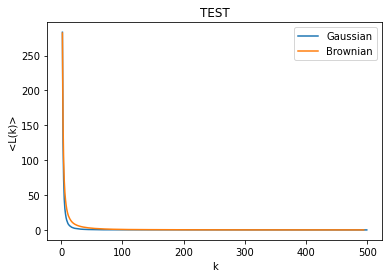

In [5]:
import math
x1 = k1 #k_interval_times
y1 = l1 #curve_length_list
x2 = k2
y2 = l2
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
#log_y = []
#for i in curve_length_list:
#  log_y.append(math.log10(i))
#y = log_y
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("TEST") 
plt.xlabel("k") 
plt.ylabel("<L(k)>")
plt.plot(x1,y1,label='Gaussian')
plt.plot(x2,y2, label='Brownian')
plt.legend() 
plt.show()

#Data Preprocessing

In [28]:
data = pd.read_csv('/content/India Data Analysis - Meta Data.csv')
data.head()

,Day,date,TS,DC,GR,Growing Inverted
0,1,02/03/2020,2.00,92609.29,2.00,93278.14
1,2,03/03/2020,8.33,92346.43,8.33,93274.57
2,3,04/03/2020,5.60,91514.29,5.60,92942.57
3,4,05/03/2020,5.14,90454.29,5.14,92765.00
4,5,06/03/2020,6.14,89349.14,6.14,91779.57


In [29]:
india=data.TS
print(india[0::])

0          2.00
1          8.33
2          5.60
3          5.14
4          6.14
         ...   
346    11054.14
347    11107.14
348    10896.00
349    10996.67
350     9086.00
Name: TS, Length: 351, dtype: float64


#Data Analysis

In [31]:
#Inputs to higuchi algorithm 
india= india[0:352:]
grow= india[0:197:]
decline= india[197:352:]
print(india.shape)
print(grow.shape)
print(decline.shape)
n=int(351/2)
k_interval_times1, curve_length_list1 = curve_length(india, n-1, n)
k_interval_times2, curve_length_list2 = curve_length(grow, n-1, n)
k_interval_times3, curve_length_list3 = curve_length(decline, n-1, n)
print(k_interval_times1, curve_length_list1)
print(k_interval_times2, curve_length_list2)
print(k_interval_times3, curve_length_list3)

(351,)
(197,)
(154,)
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174] [95658.04525862 62842.5        46788.90012906 37283.29756522
 30970.84441168 26424.92827988 23012.33861737 20328.30840734
 18176.32047059 16418.29223884 14976.88190952 13777.58732187
 12748.70380952 11894.34308388 11136.11848958 10473.48471884
  9890.14200915  9348.37302904  

In [32]:
hfd(india)

1.160121360409287

In [33]:
hfd(grow)

1.021526900363605

In [34]:
hfd(decline)

1.0608363610737706

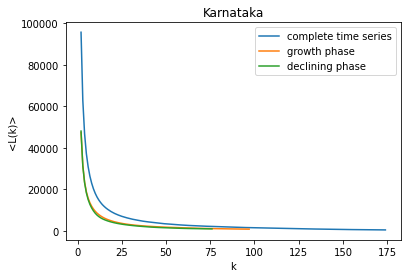

In [37]:
#The Graphs

x1 = k_interval_times1
y1 = curve_length_list1
x2 = k_interval_times2
y2 = curve_length_list2
x3 = k_interval_times3
y3 = curve_length_list3
plt.title("Karnataka") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x1,y1,label='complete time series')
plt.plot(x2,y2,label='growth phase')  
plt.plot(x3,y3,label='declining phase')
plt.legend()
plt.show()